# 1 Introduction

As the field of artificial intelligence (AI) continues to develop and improve, so does advancements in text generation. This progress presents the challenge of distinguishing between human-generated versus AI-generated text. This report addresses that task of developing a system to classify text based on human or AI author. Exploring this problem contributes to the broader understanding of AI-generated content and.

## 1.1 Background

The ability to generate coherent and realistic text has become a hallmark of recent AI models, such as large language models (LLMs). These systems are widely used in various applications, including content creation, chatbots, and summarization tools. However, the indistinguishability of AI-generated text from human-authored content raises concerns about misuse, authenticity, and misinformation. As a result, there is a growing need for tools that can reliably identify AI-generated text and differentiate it from human-written content.


## 1.2 Problem Description

This project focuses on building a machine learning model capable of classifying text as either human-written or AI-generated. The task involves analyzing textual features, leveraging patterns indicative of AI generation, and building a classifier to make accurate predictions. The key challenges include addressing the subtle similarities between human and AI-generated writing, ensuring model generalization across diverse text types, and evaluating performance using a robust metric.

## 1.3 Dataset

The dataset for this project consists of labeled training examples and an unlabeled test set. The training data contains pairs of text samples and their corresponding labels, indicating whether the text is human-written or AI-generated. Additionally, a set of prompts is provided to contextualize the training samples. The test set contains text samples for which predictions are to be made. This dataset offers a balanced mix of content, enabling the development of a model capable of distinguishing nuanced differences between human and AI-generated text.


### Data Import

The orignal data can be found at: 

https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import string
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib_venn import venn2

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Preprocessing
from sklearn.preprocessing import MaxAbsScaler  
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Model training and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_essays_file = "train_essays.csv"
train_prompts_file = "train_prompts.csv"
test_essays_file = "test_essays.csv"
sample_submission_file = "sample_submission.csv"

# Load datasets
train_essays_df = pd.read_csv(train_essays_file)
train_prompts_df = pd.read_csv(train_prompts_file)
test_essays_df = pd.read_csv(test_essays_file)
sample_submission_df = pd.read_csv(sample_submission_file)

print("Train Essays Data:")
display(train_essays_df.head())

print("\nTrain Prompts Data:")
display(train_prompts_df.head())

print("\nTest Essays Data:")
display(test_essays_df.head())

print("\nSample Submission:")
display(sample_submission_df.head())

Train Essays Data:


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0



Train Prompts Data:


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...



Test Essays Data:


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.



Sample Submission:


,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


## 1.4 Initial Dataset Overview

The dataset comprises three components: train_essays, train_prompts, and test_essays. Each dataset was examined to understand its structure, characteristics, and completeness. Below is a summary of the findings for each component:

#### Train Essays

The train_essays dataset consists of 1,378 rows and 4 columns: id, prompt_id, text, and generated. The dataset is free of missing values and duplicate rows.

Unique Values: The id column contains 1,378 unique identifiers, ensuring that each row represents a distinct essay. There are two unique prompt_id values, corresponding to the two prompts provided in the train_prompts dataset. Each essay has unique content in the text column. The generated column contains binary values (0 or 1), with a majority class of 0, indicating most essays are human-written.

Descriptive Statistics: The prompt_id column has a mean of approximately 0.49, reflecting an even distribution of essays across the two prompts. The generated column has a low mean of 0.002, consistent with the observed class imbalance.

#### Train Prompts

The train_prompts dataset contains 2 rows and 4 columns: prompt_id, prompt_name, instructions, and source_text.

Unique Values: All columns have 2 unique values, confirming that each prompt is distinct.

Descriptive Statistics: The prompt_id column has values of 0 and 1, corresponding to the two prompts, with a mean of 0.5.

Data Completeness: There are no missing values or duplicate rows.

#### Test Essays
The test_essays dataset includes 3 rows and 3 columns: id, prompt_id, and text. Each row represents a unique essay that requires classification.

#### General Observations

- The datasets are well-structured, with no missing or duplicate data.

- The train_essays dataset exhibits class imbalance in the generated column, which will require attention during model training to ensure balanced performance.

- The train_prompts dataset provides essential context for the essays, enabling alignment between prompts and their associated instructions.

- The test_essays dataset is small, containing only three samples, which suggests a controlled environment for evaluation.

In [3]:
def dataset_overview(df, dataset_name):
    print(f"\n--- {dataset_name} Overview ---\n")
    
    print(f"Shape: {df.shape}\n")
    
    print("Columns and Data Types:")
    print(df.dtypes)
    
    print("\nUnique Values Per Column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    print("\nNull Values Per Column:")
    print(df.isnull().sum())
    
    print("\nFirst 5 Rows:")
    display(df.head())
    
    print("\nDescriptive Statistics (Numeric Columns):")
    print(df.describe())
    
    duplicate_rows = df.duplicated().sum()
    print(f"\nNumber of Duplicate Rows: {duplicate_rows}")

dataset_overview(train_essays_df, "Train Essays")
dataset_overview(train_prompts_df, "Train Prompts")
dataset_overview(test_essays_df, "Test Essays")


--- Train Essays Overview ---

Shape: (1378, 4)

Columns and Data Types:
id           object
prompt_id     int64
text         object
generated     int64
dtype: object

Unique Values Per Column:
id: 1378 unique values
prompt_id: 2 unique values
text: 1378 unique values
generated: 2 unique values

Null Values Per Column:
id           0
prompt_id    0
text         0
generated    0
dtype: int64

First 5 Rows:


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0



Descriptive Statistics (Numeric Columns):
         prompt_id    generated
count  1378.000000  1378.000000
mean      0.486212     0.002177
std       0.499991     0.046625
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       1.000000     0.000000
max       1.000000     1.000000

Number of Duplicate Rows: 0

--- Train Prompts Overview ---

Shape: (2, 4)

Columns and Data Types:
prompt_id        int64
prompt_name     object
instructions    object
source_text     object
dtype: object

Unique Values Per Column:
prompt_id: 2 unique values
prompt_name: 2 unique values
instructions: 2 unique values
source_text: 2 unique values

Null Values Per Column:
prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64

First 5 Rows:


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...



Descriptive Statistics (Numeric Columns):
       prompt_id
count   2.000000
mean    0.500000
std     0.707107
min     0.000000
25%     0.250000
50%     0.500000
75%     0.750000
max     1.000000

Number of Duplicate Rows: 0

--- Test Essays Overview ---

Shape: (3, 3)

Columns and Data Types:
id           object
prompt_id     int64
text         object
dtype: object

Unique Values Per Column:
id: 3 unique values
prompt_id: 3 unique values
text: 3 unique values

Null Values Per Column:
id           0
prompt_id    0
text         0
dtype: int64

First 5 Rows:


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.



Descriptive Statistics (Numeric Columns):
       prompt_id
count        3.0
mean         3.0
std          1.0
min          2.0
25%          2.5
50%          3.0
75%          3.5
max          4.0

Number of Duplicate Rows: 0


## 1.5 Additional Dataset

To address the imbalance between AI-generated and human-written essays, two additional datasets were incorporated: one containing AI-generated essays and the other containing GPT-4 generated essays. These datasets were loaded, concatenated with the original training data, and duplicates were removed to form a combined dataset. The resulting dataset contains 2,078 entries, with columns for essay ID, prompt ID, essay text, and a "generated" label indicating that they were AI-generated.

Avaiable here:
https://www.kaggle.com/datasets/radek1/llm-generated-essays

In [4]:
# Load the two additional datasets
ai_generated_essays_df = pd.read_csv('ai_generated_train_essays.csv')
ai_generated_gpt4_essays_df = pd.read_csv('ai_generated_train_essays_gpt-4.csv')
ai_generated_essays_df.head(), ai_generated_gpt4_essays_df.head()

# Combine training datasets
combined_train_essays = pd.concat([train_essays_df, ai_generated_essays_df, ai_generated_gpt4_essays_df], ignore_index=True)
combined_train_essays = combined_train_essays.drop_duplicates()

print(combined_train_essays.shape)
print(combined_train_essays.head())

(2078, 4)
         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  


In [5]:
print(combined_train_essays.info())
print(combined_train_essays.head())

print(combined_train_essays.describe())

missing_values = combined_train_essays.isnull().sum()
print("Missing values in each column:")
print(missing_values)

print("Unique values per column:")
print(combined_train_essays.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         2078 non-null   object
 1   prompt_id  2078 non-null   int64 
 2   text       2078 non-null   object
 3   generated  2078 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 65.1+ KB
None
         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  
         prompt_id    generated
count  2078.000000 

# 2 Exploratory Data Analysis

In this section, distribution of datasets is explored to understand the class balance and data characteristics. Visualizations such as histograms or bar charts were used to analyze the frequency of each class label, helping to identify any potential class imbalance that might affect model performance. A balanced distribution is crucial for ensuring the model is trained effectively without bias towards a particular class.

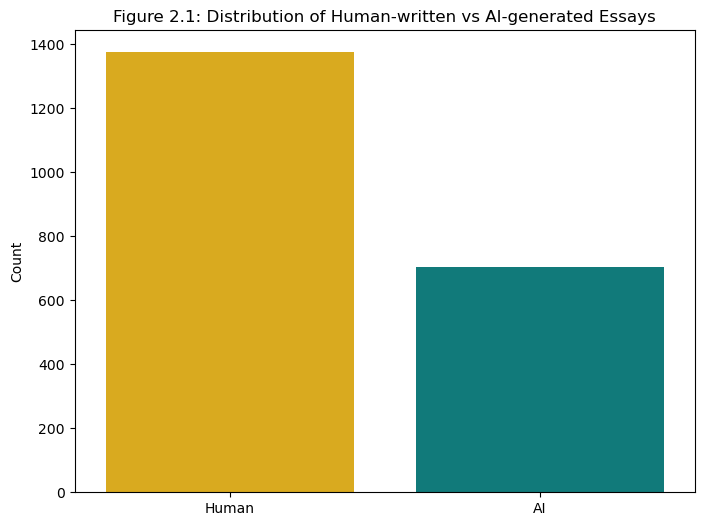

In [6]:
combined_train_essays['generated'] = combined_train_essays['generated'].astype(str)

# Define custom colors for human (0) and AI (1)
human_color = "#F8B900"  # Saffron for Human
ai_color = "#008B8B"  # Soft Teal for AI

plt.figure(figsize=(8, 6))
sns.countplot(x='generated', hue='generated', data=combined_train_essays, palette={'0': human_color, '1': ai_color}, legend=False)

plt.xticks(ticks=[0, 1], labels=['Human', 'AI'])

plt.title('Figure 2.1: Distribution of Human-written vs AI-generated Essays')
plt.ylabel('Count')
plt.xlabel('')

plt.show()

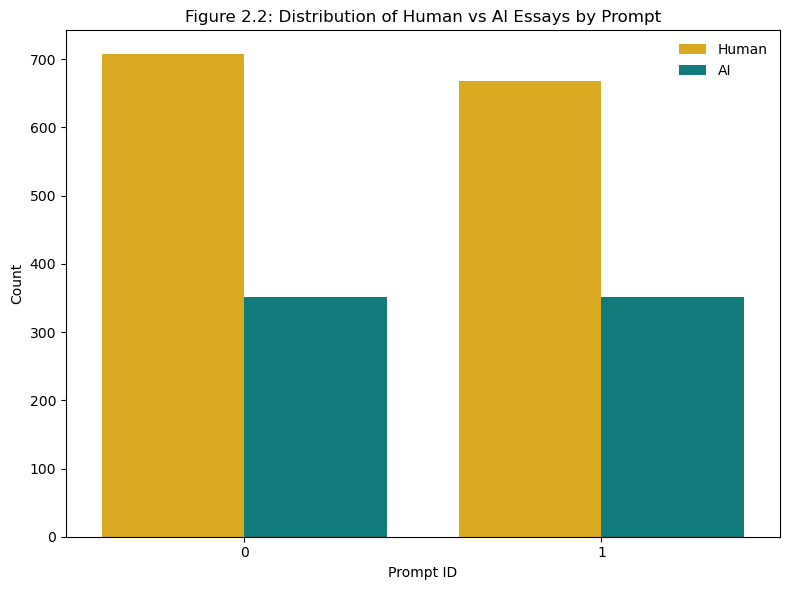

In [7]:
combined_train_essays['generated'] = combined_train_essays['generated'].astype(int)

plt.figure(figsize=(8, 6))

sns.countplot(x='prompt_id', hue='generated', data=combined_train_essays, palette={0: human_color, 1: ai_color})

plt.title('Figure 2.2: Distribution of Human vs AI Essays by Prompt')
plt.xlabel('Prompt ID')
plt.ylabel('Count')

plt.legend(title=None, labels=['Human', 'AI'], loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

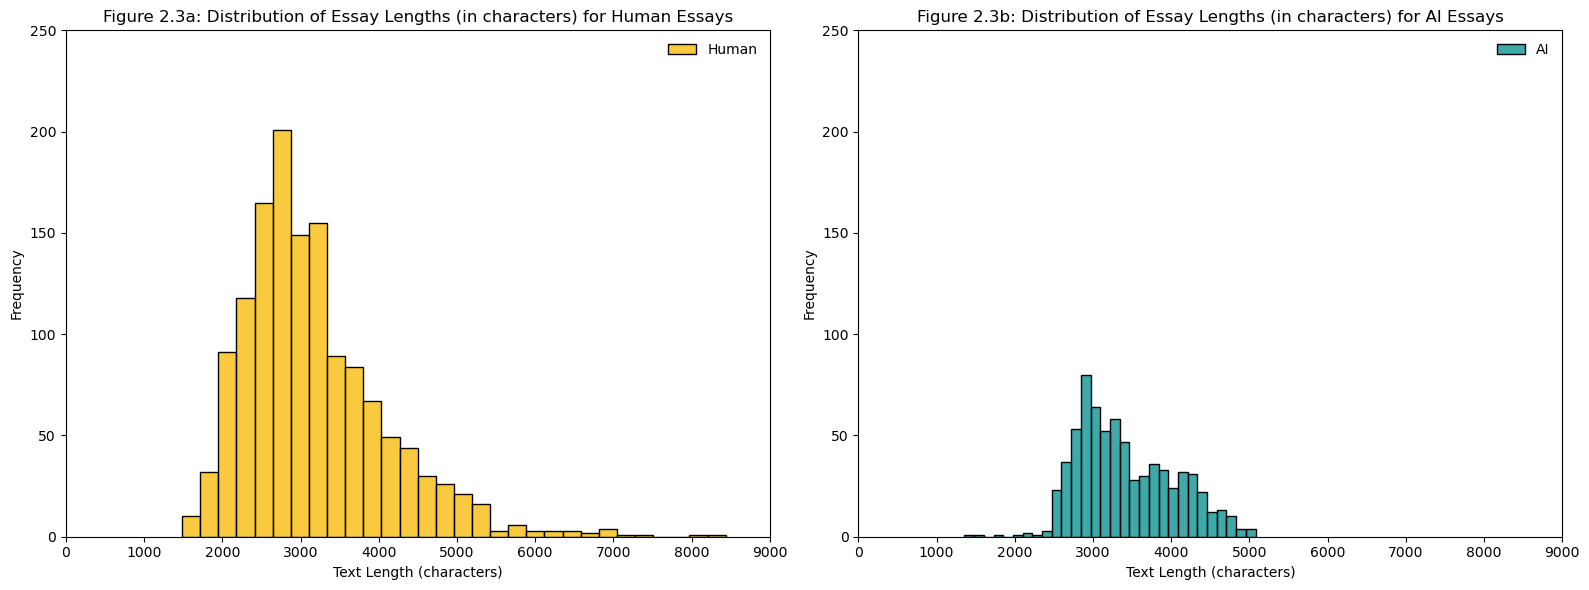

In [8]:
combined_train_essays['text_length'] = combined_train_essays['text'].apply(len)

# Separate by generated (Human vs AI) 
human_data = combined_train_essays[combined_train_essays['generated'] == 0]
ai_data = combined_train_essays[combined_train_essays['generated'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(human_data['text_length'], color=human_color, bins=30, kde=False, ax=axes[0], label='Human')
axes[0].set_title('Figure 2.3a: Distribution of Essay Lengths (in characters) for Human Essays')
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].legend(title=None, labels=['Human'], loc='upper right', frameon=False)

sns.histplot(ai_data['text_length'], color=ai_color, bins=30, kde=False, ax=axes[1], label='AI')
axes[1].set_title('Figure 2.3b: Distribution of Essay Lengths (in characters) for AI Essays')
axes[1].set_xlabel('Text Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].legend(title=None, labels=['AI'], loc='upper right', frameon=False)

axes[0].set_xlim(0, 9000)
axes[1].set_xlim(0, 9000)
axes[0].set_ylim(0, 250)
axes[1].set_ylim(0, 250)

plt.tight_layout()
plt.show()

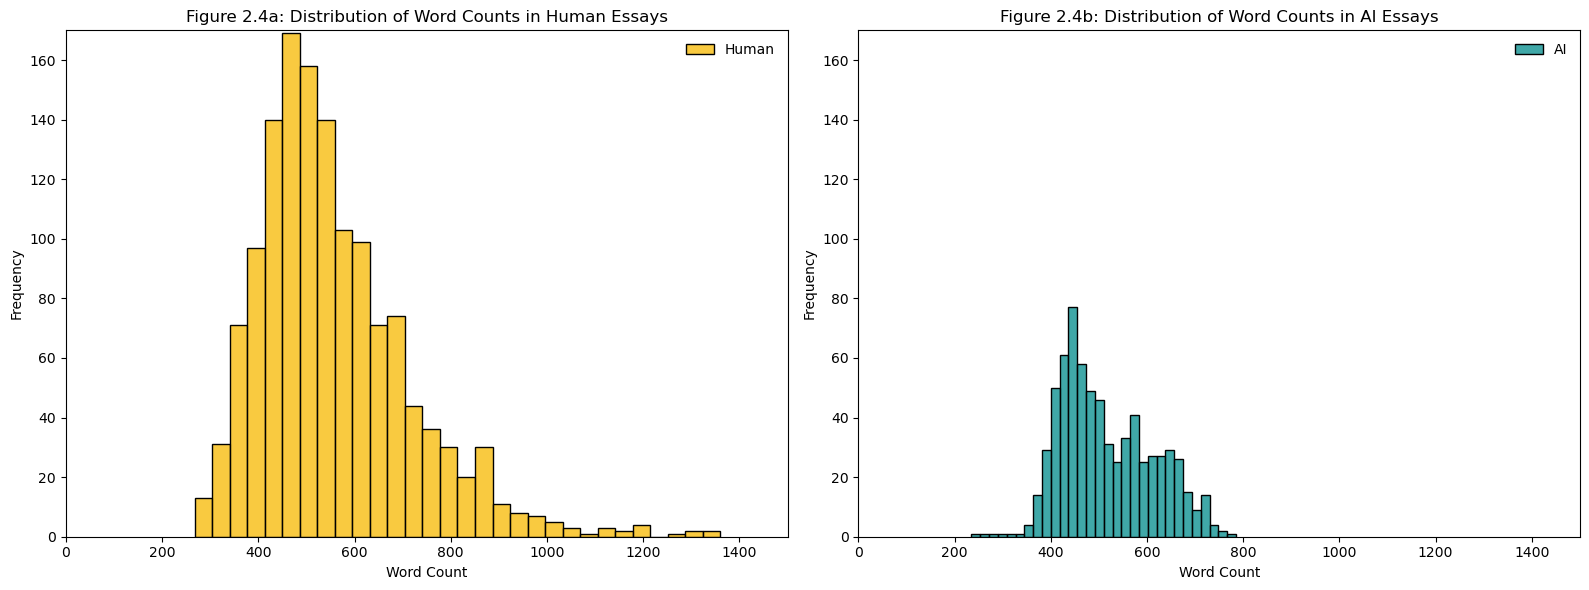

In [9]:
combined_train_essays['word_count'] = combined_train_essays['text'].apply(lambda x: len(x.split()))

human_data = combined_train_essays[combined_train_essays['generated'] == 0].copy()
ai_data = combined_train_essays[combined_train_essays['generated'] == 1].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(human_data['word_count'], color=human_color, bins=30, kde=False, ax=axes[0], label='Human')
axes[0].set_title('Figure 2.4a: Distribution of Word Counts in Human Essays')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend(title=None, labels=['Human'], loc='upper right', frameon=False)

sns.histplot(ai_data['word_count'], color=ai_color, bins=30, kde=False, ax=axes[1], label='AI')
axes[1].set_title('Figure 2.4b: Distribution of Word Counts in AI Essays')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend(title=None, labels=['AI'], loc='upper right', frameon=False)

axes[0].set_xlim(0, 1500)
axes[1].set_xlim(0, 1500)
axes[0].set_ylim(0, 170)
axes[1].set_ylim(0, 170)

plt.tight_layout()
plt.show()

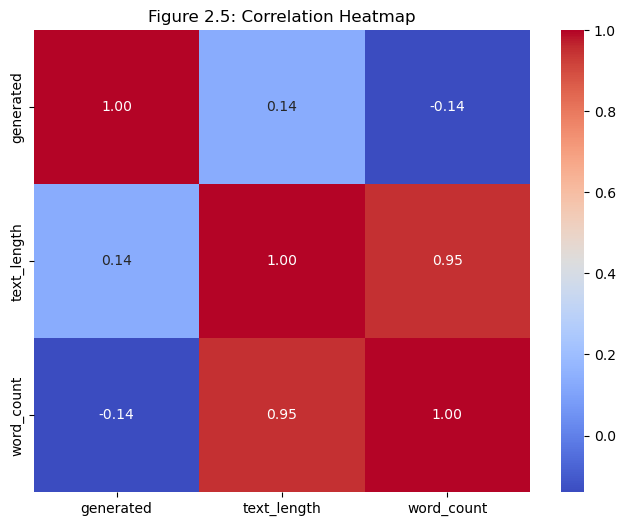

In [10]:
# Check for any correlation between numeric variables
correlation_matrix = combined_train_essays[['generated', 'text_length', 'word_count']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Figure 2.5: Correlation Heatmap')
plt.show()

Number of unique words in Human-written Essays: 27080
Number of unique words in AI-generated Essays: 9493


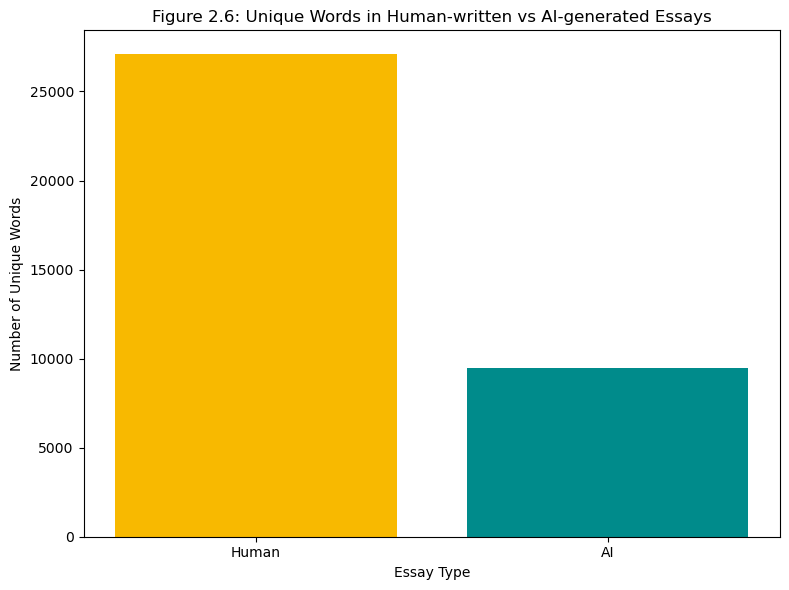

In [11]:
# Tokenizer function to split text into words
def tokenize(text):
    return text.lower().split()

human_written_essays = combined_train_essays[combined_train_essays['generated'] == 0]['text']
ai_generated_essays = combined_train_essays[combined_train_essays['generated'] == 1]['text']

human_written_tokens = human_written_essays.apply(tokenize)
ai_generated_tokens = ai_generated_essays.apply(tokenize)

# Flatten the lists of tokens and calculate unique words
human_written_unique_words = set(word for essay in human_written_tokens for word in essay)
ai_generated_unique_words = set(word for essay in ai_generated_tokens for word in essay)

num_human_written_unique_words = len(human_written_unique_words)
num_ai_generated_unique_words = len(ai_generated_unique_words)

# Word overlap: Jaccard Similarity
overlap = len(human_written_unique_words.intersection(ai_generated_unique_words))
union = len(human_written_unique_words.union(ai_generated_unique_words))
jaccard_similarity = overlap / union if union != 0 else 0

print(f'Number of unique words in Human-written Essays: {num_human_written_unique_words}')
print(f'Number of unique words in AI-generated Essays: {num_ai_generated_unique_words}')

plt.figure(figsize=(8, 6))
plt.bar(['Human', 'AI'], [num_human_written_unique_words, num_ai_generated_unique_words], 
        color=[human_color, ai_color])

plt.title('Figure 2.6: Unique Words in Human-written vs AI-generated Essays')
plt.xlabel('Essay Type')
plt.ylabel('Number of Unique Words')
plt.tight_layout()
plt.show()


Jaccard Similarity (Word Overlap): 0.1923


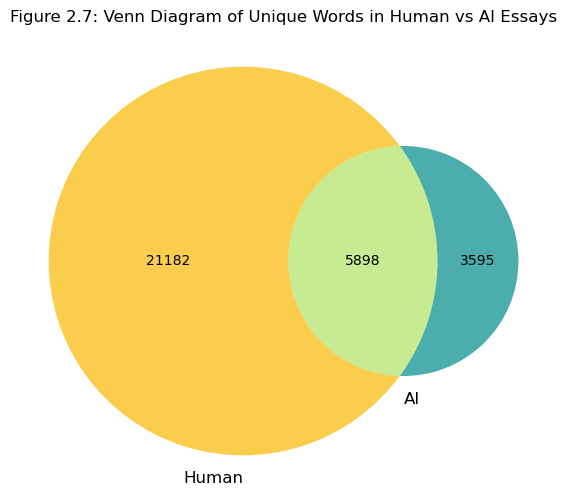

In [12]:
print(f'Jaccard Similarity (Word Overlap): {jaccard_similarity:.4f}')

plt.figure(figsize=(8, 6))
venn2(subsets=(len(human_written_unique_words - ai_generated_unique_words), 
                len(ai_generated_unique_words - human_written_unique_words), 
                len(human_written_unique_words & ai_generated_unique_words)),
      set_labels=('Human', 'AI'),
      set_colors=(human_color, ai_color),
      alpha=0.7)

plt.title('Figure 2.7: Venn Diagram of Unique Words in Human vs AI Essays')
plt.show()

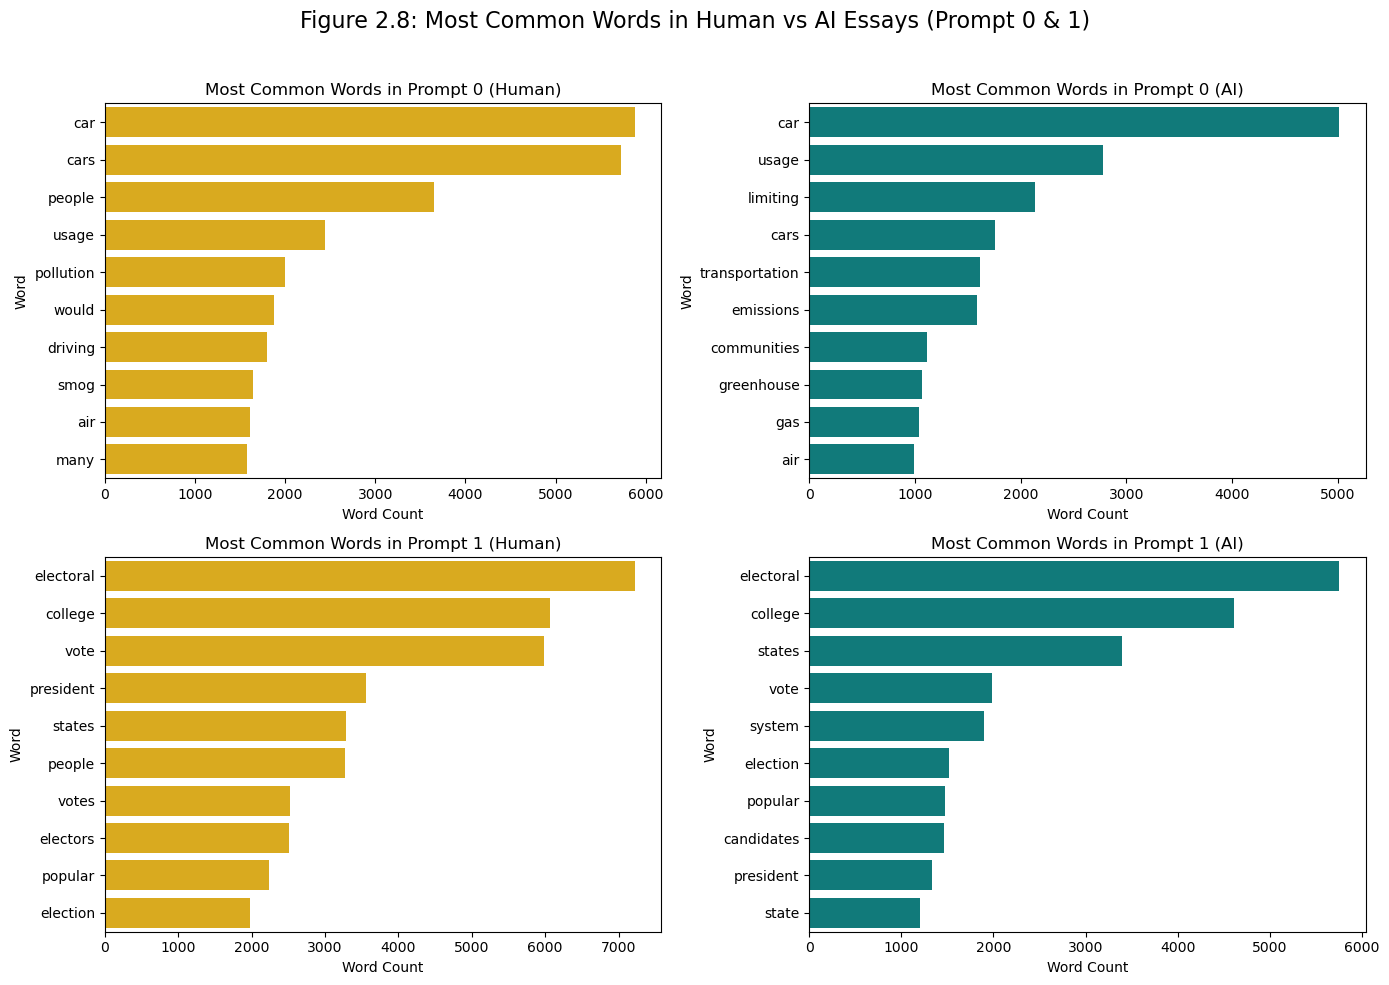

In [13]:
stop_words = stopwords.words('english')

human_color = "#F8B900"  # Saffron for Human
ai_color = "#008B8B"  # Soft Teal for AI

# Function to get the top N words from a set of essays
def get_top_n_words(essays, n=10):
    vectorizer = CountVectorizer(stop_words=stop_words, max_features=50)
    X = vectorizer.fit_transform(essays)
    words = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    word_count = dict(zip(words, counts))
    sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    return sorted_word_count[:n]

def plot_top_n_by_generated_and_prompt(prompt_id, ax1, ax2):
    # Filter essays for the specific prompt
    prompt_essays = combined_train_essays[combined_train_essays['prompt_id'] == prompt_id]

    # Top N for human essays
    human_essays = prompt_essays[prompt_essays['generated'] == 0]['text']
    top_n_human = get_top_n_words(human_essays)
    top_n_human_df = pd.DataFrame(top_n_human, columns=['Word', 'Count'])

    # Top N for AI essays
    ai_essays = prompt_essays[prompt_essays['generated'] == 1]['text']
    top_n_ai = get_top_n_words(ai_essays)
    top_n_ai_df = pd.DataFrame(top_n_ai, columns=['Word', 'Count'])

    # Plot human words
    sns.barplot(x='Count', y='Word', data=top_n_human_df, color=human_color, ax=ax1)
    ax1.set_title(f'Most Common Words in Prompt {prompt_id} (Human)')
    ax1.set_xlabel('Word Count')
    ax1.set_ylabel('Word')

    # Plot AI words
    sns.barplot(x='Count', y='Word', data=top_n_ai_df, color=ai_color, ax=ax2)
    ax2.set_title(f'Most Common Words in Prompt {prompt_id} (AI)')
    ax2.set_xlabel('Word Count')
    ax2.set_ylabel('Word')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plot_top_n_by_generated_and_prompt(0, axes[0, 0], axes[0, 1])
plot_top_n_by_generated_and_prompt(1, axes[1, 0], axes[1, 1])

fig.suptitle('Figure 2.8: Most Common Words in Human vs AI Essays (Prompt 0 & 1)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# 3 Feature Engineering

In this section, the focus was on cleaning and preprocessing the text data, followed by handling class imbalance using SMOTE (Synthetic Minority Over-sampling Technique). The following steps were performed:

1. **Text Cleaning**: The `clean_text` function was applied to the text data, which included:
   - Converting all text to lowercase to ensure uniformity.
   - Removing punctuation and stop words to focus on meaningful content.
   - Lemmatizing the words to reduce them to their base forms, improving the quality of the text data.

2. **Splitting Data**: The cleaned text data (`X`) was split into training and testing sets (`X_train` and `X_test`), with `y_train` and `y_test` representing the corresponding target labels.

3. **TF-IDF Transformation**: The text data was transformed into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency), which is a common method to convert raw text into a format suitable for machine learning models.

4. **Handling Class Imbalance with SMOTE**: To address the class imbalance between the "Human" and "AI" labels, SMOTE was applied to the training data. This technique generates synthetic samples for the minority class, effectively balancing the class distribution in the training set.

5. **Normalization**: The resampled training set was normalized using the MaxAbsScaler, which scales the features without affecting the sparsity of the data. The same scaler was then applied to the test set to ensure consistency in the feature space.

6. **Class Distribution**: The class distribution of the training data was visualized before and after applying SMOTE. Prior to SMOTE, the data was imbalanced, with more instances of the "Human" class. After applying SMOTE, the class distribution was balanced, with equal instances of both classes (Human and AI).

The visualizations in **Figure 3.1** demonstrate the class label distribution before and after SMOTE, confirming that the imbalance was successfully addressed.

This preprocessing ensures that the data is well-prepared for subsequent machine learning models, with balanced class representation to avoid bias during training.

In [14]:
X = combined_train_essays['text']  
y = combined_train_essays['generated']  

# Initialize necessary preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    
    return text

X = X.apply(clean_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert text data into numerical features using TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)  
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Normalize the resampled training set using MaxAbsScaler
scaler = MaxAbsScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Normalize the resampled training data

# Apply the same preprocessing to the test dataset
X_test_essays = test_essays_df['text']
X_test_essays = X_test_essays.apply(clean_text)

# Convert test essays to TF-IDF features
X_test_essays_tfidf = tfidf.transform(X_test_essays)

# Normalize the test set using the same scaler
X_test_essays_tfidf = scaler.transform(X_test_essays_tfidf) 

print(f"Before SMOTE:\n{y_train.value_counts()}")
print(f"After SMOTE:\n{y_train_resampled.value_counts()}")


Before SMOTE:
generated
0    1100
1     562
Name: count, dtype: int64
After SMOTE:
generated
1    1100
0    1100
Name: count, dtype: int64


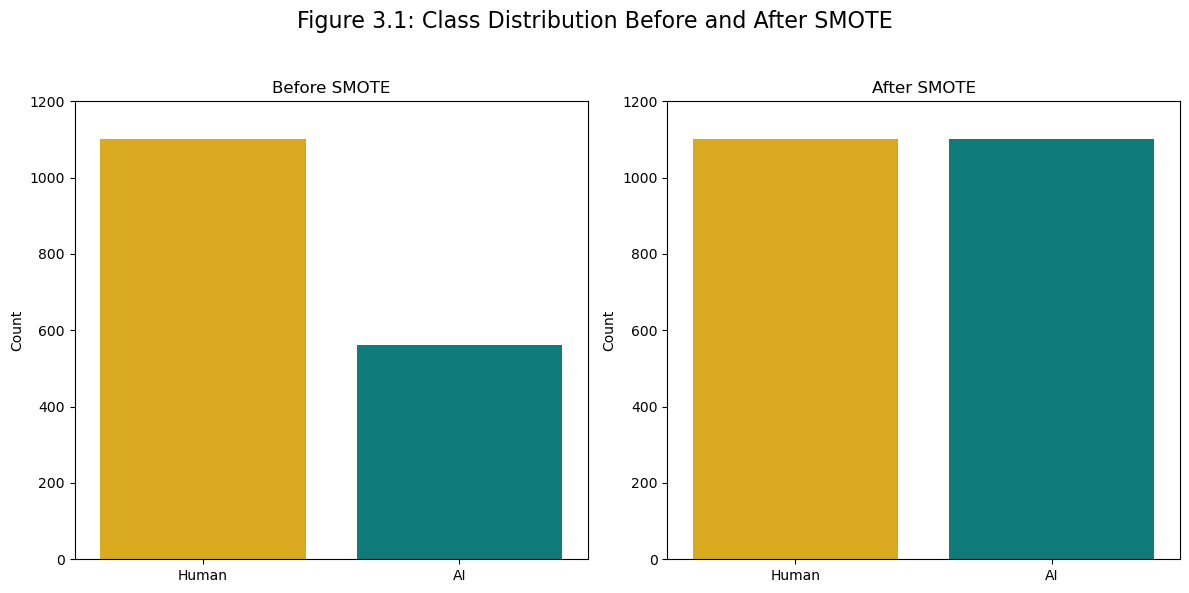

In [15]:
human_color = "#F8B900"  
ai_color = "#008B8B"    

class_counts_before = y_train.value_counts().sort_index()
class_counts_after = y_train_resampled.value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=class_counts_before.index, y=class_counts_before.values, 
            palette=[human_color, ai_color], ax=axes[0], hue=class_counts_before.index, legend=False)
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')

axes[0].set_xticks([0, 1])  # Set the tick positions
axes[0].set_xticklabels(['Human', 'AI'])  # Custom x-axis labels
axes[0].set_ylim(0, max(class_counts_before.max(), class_counts_after.max()) + 100)  # same y-axis scale

sns.barplot(x=class_counts_after.index, y=class_counts_after.values, 
            palette=[human_color, ai_color], ax=axes[1], hue=class_counts_after.index, legend=False)
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')

axes[1].set_xticks([0, 1])  # Set the tick positions
axes[1].set_xticklabels(['Human', 'AI'])  # Custom x-axis labels
axes[1].set_ylim(0, max(class_counts_before.max(), class_counts_after.max()) + 100)

fig.suptitle('Figure 3.1: Class Distribution Before and After SMOTE', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 4 Model Architecture 

This section outlines the classification models applied to the dataset, with a focus on their structure, rationale for use, and performance evaluation. Both traditional machine learning and deep learning methods were explored.

## 4.1 Random Forest Classifier

The Random Forest Classifier is an ensemble method that constructs multiple decision trees during training and outputs the mode of their predictions. It is known for its robustness to overfitting and its ability to handle high-dimensional, sparse datasets — making it well-suited for TF-IDF-transformed text data.

Implementation Details

- Model Type: Random Forest (Ensemble of Decision Trees)

- Vectorization: TF-IDF

- Resampling Strategy: SMOTE applied to training data to handle class imbalance

The model was evaluated using standard classification metrics including precision, recall, F1-score, and accuracy.

In [16]:
# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = rf_model.predict(X_test_tfidf)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       275
           1       1.00      0.90      0.95       141

    accuracy                           0.97       416
   macro avg       0.98      0.95      0.96       416
weighted avg       0.97      0.97      0.97       416

Accuracy: 0.9663461538461539


ROC-AUC Score: 0.9985


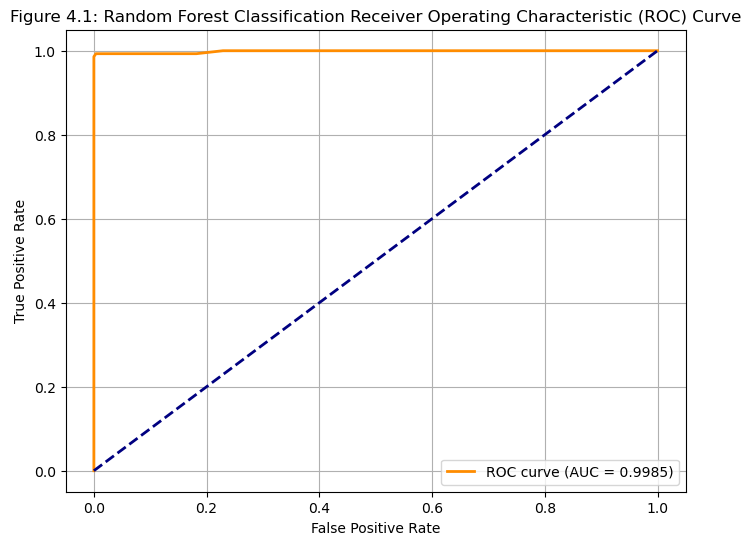

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_proba = rf_model.predict_proba(X_test_tfidf)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Figure 4.1: Random Forest Classification Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 4.2 LSTM Model

LSTM networks are a type of recurrent neural network (RNN) that excel in capturing sequential patterns in text, making them particularly effective for Natural Language Processing (NLP) tasks involving classification, sentiment analysis, and more.

The raw text data needs to be tokenized into sequences of integers before feeding it into an LSTM model:

In [18]:
# Tokenization parameters
max_num_words = 10000  
max_sequence_length = 500  

# Fit the tokenizer on the cleaned training text
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

This LSTM model is a a simple sequential model consisting of an Embedding layer followed by an LSTM layer and a final Dense output layer.

Model Architecture:

- Embedding Layer: Transforms integer sequences into dense vector representations.

- LSTM Layer: Captures sequential dependencies. Dropout is applied to prevent overfitting.

- Dense Output Layer: A sigmoid activation for binary classification.

The model is compiled with the binary cross-entropy loss function, appropriate for binary classification tasks, and optimized using Adam.

In [19]:
# Hyperparameters
max_sequence_length = 500  
embedding_dim = 100       

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

y_pred_dl = (model.predict(X_test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_dl))
print(f"Accuracy: {accuracy_score(y_test, y_pred_dl)}")

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 955ms/step - accuracy: 0.7098 - loss: 0.5876 - val_accuracy: 0.9952 - val_loss: 0.0761
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9944 - loss: 0.0635 - val_accuracy: 0.9736 - val_loss: 0.0929
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9977 - loss: 0.0146 - val_accuracy: 0.9976 - val_loss: 0.0186
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9977 - loss: 0.0129 - val_accuracy: 0.9952 - val_loss: 0.0232
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9963 - loss: 0.0195 - val_accuracy: 0.9928 - val_loss: 0.0357
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       275
           1       0.99      0.99      0.99       141

    accuracy                           0.99       416
   macro avg       0.99      0.99      0.99       416
weighted avg       0.99      0.99      0.99       416

Accu

In [20]:
# Predict probabilities instead of hard labels
y_proba_dl = model.predict(X_test_padded)

# Compute AUC
roc_auc = roc_auc_score(y_test, y_proba_dl)
print(f"ROC-AUC Score: {roc_auc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
ROC-AUC Score: 0.9946


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


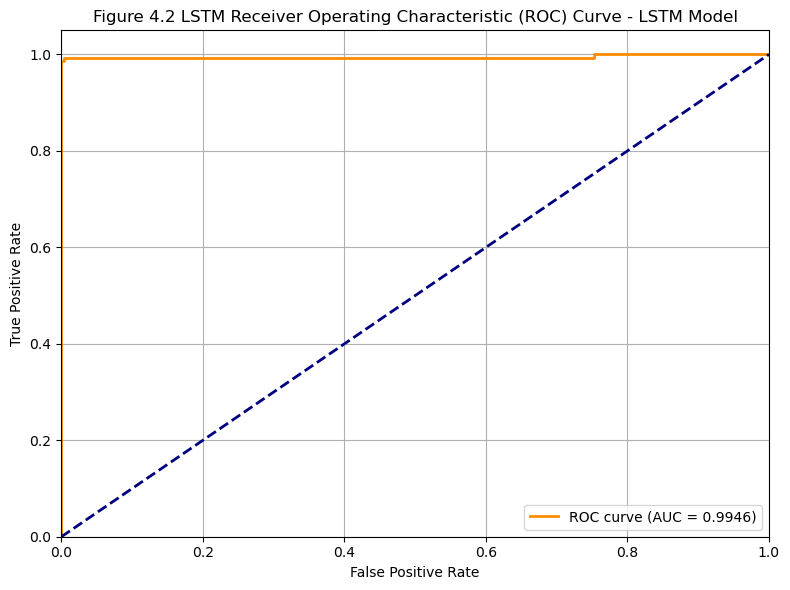

In [21]:
# Get predicted probabilities instead of hard class predictions
y_pred_proba = model.predict(X_test_padded)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Figure 4.2 LSTM Receiver Operating Characteristic (ROC) Curve - LSTM Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# 5 Final Model and Conclusion

The LSTM model achieved a ROC-AUC score of 0.9946, further confirming its exceptional ability to separate positive and negative cases. This score complements the near-perfect precision and recall metrics, demonstrating that the model performs well even under varying decision thresholds. This is particularly important in cases where false positives and false negatives have different costs.

To further enhance sequential context capture, a Bidirectional LSTM (BiLSTM) was implemented. Unlike a standard LSTM, which processes text in one direction (typically forward), a Bidirectional LSTM reads the input sequence in both forward and backward directions. This allows the model to retain information from both past and future context within a sequence, which is especially useful when detecting patterns that depend on surrounding words—common in natural language.

The Bidirectional LSTM model was trained over five epochs and demonstrated near-perfect classification results on the test set, with an overall accuracy of 99.76%. The classification report shows an F1-score of 1.00 for human-generated text and 1.00 for AI-generated text, with only minimal errors on the minority class. The ROC-AUC score of 0.9939 confirms that the model maintains strong discriminative ability even across various thresholds.

The ROC curve below illustrates the model's performance, showing a curve that hugs the top-left corner—indicative of a highly effective binary classifier.

In [22]:
# Build the Bidirectional LSTM model
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_sequence_length))
bilstm_model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
bilstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

# Evaluate the model
y_pred_bilstm = (bilstm_model.predict(X_test_padded) > 0.5).astype("int32")

# Print performance metrics
print("Bidirectional LSTM Classification Report:")
print(classification_report(y_test, y_pred_bilstm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_bilstm)}")

# ROC-AUC Score
print(f"ROC-AUC Score: {roc_auc_score(y_test, bilstm_model.predict(X_test_padded)):.4f}")

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6791 - loss: 0.5848 - val_accuracy: 0.9952 - val_loss: 0.0616
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9743 - loss: 0.0913 - val_accuracy: 0.9904 - val_loss: 0.0734
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9943 - loss: 0.0451 - val_accuracy: 0.9976 - val_loss: 0.0262
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9983 - loss: 0.0169 - val_accuracy: 0.9976 - val_loss: 0.0190
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9976 - loss: 0.0098 - val_accuracy: 0.9976 - val_loss: 0.0200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Bidirectional LSTM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      0.99      1.00       141

    accuracy                           1.00       416
   macro avg       1.00      1.00      1.00       416
weighted avg       1

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


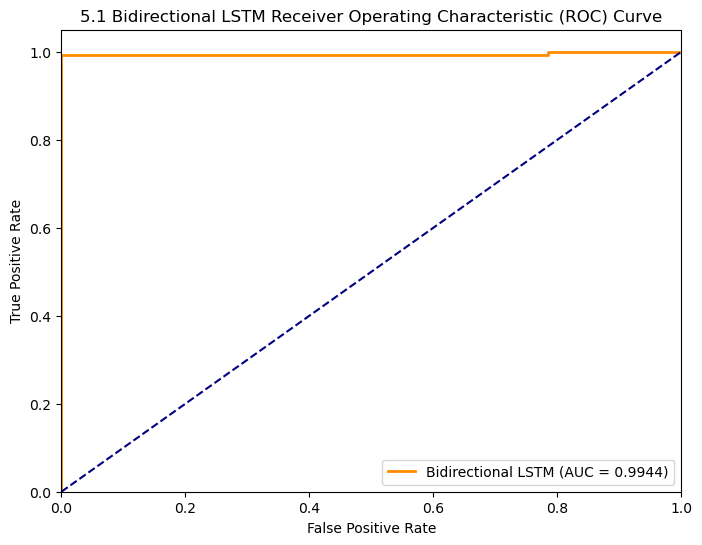

In [23]:
# Calculate ROC-AUC for the Bidirectional LSTM model
y_pred_bilstm_prob = bilstm_model.predict(X_test_padded)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_bilstm_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Bidirectional LSTM (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5.1 Bidirectional LSTM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()